# SSNR analysis
---

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr
import noise

In [3]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

## White noise
---
### Generate noisy images

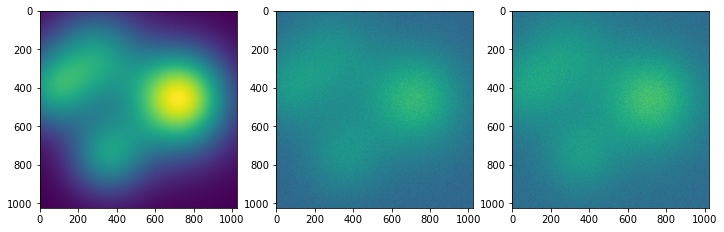

In [4]:
# Parameters
np.random.seed(123)
SNR_set = 1

# Generate image
image = noise.generate_image(1024, 1024)
var = np.var(image)
# Add noise
noisy_1 = image + noise.white_noise(var / SNR_set, image.shape)
noisy_2 = image + noise.white_noise(var / SNR_set, image.shape)

# Plot images
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes[0].imshow(image)
axes[1].imshow(noisy_1)
axes[2].imshow(noisy_2);

### SSNR

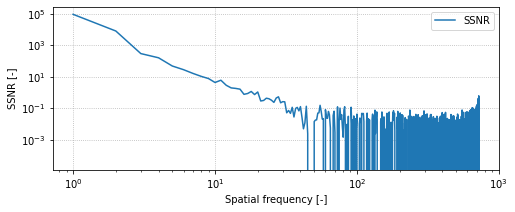

In [5]:
# Direct SSNR calculation
SSNR_data = ssnr.SSNR_ring([noisy_1, noisy_2])

# Plot SSNR data
fig, ax = plt.subplots(figsize=(8, 3))
ax.loglog(SSNR_data, label='SSNR')
ax.set_xlabel('Spatial frequency [-]')
ax.set_ylabel('SSNR [-]')
ax.legend()
ax.grid(ls=':')

### SNR calculations

In [6]:
# From PSD
SNR_JOY = (ssnr.SNR_JOY(noisy_1) +
           ssnr.SNR_JOY(noisy_2)) / 2
# From SSNR
SNR_SSNR = ssnr.SSNR_full([noisy_1, noisy_2])

# Output
out = f"""\
True SNR........ {SNR_set:.10f}
SNR from JOY.... {SNR_JOY:.10f}
SNR from SSNR... {SNR_SSNR:.10f}
"""
print(out)

True SNR........ 1.0000000000
SNR from JOY.... 0.3332384735
SNR from SSNR... 0.9988911800



## Batch of images with white noise
---

In [7]:
# Set up DataFrame
df = pd.DataFrame(columns=['SNR', 'SNR SSNR', 'SNR JOY'])
df['SNR'] = np.geomspace(1e-4, 1e4, 30)

for i, row in df.iterrows():
    SNR = row['SNR']

    # Generate noisy images
    noisy_1 = image + noise.white_noise(var/SNR, image.shape)
    noisy_2 = image + noise.white_noise(var/SNR, image.shape)

    # (S)SNR calculations
    df.loc[i, 'SNR SSNR'] = ssnr.SSNR_full([noisy_1, noisy_2])
    df.loc[i, 'SNR JOY'] = (ssnr.SNR_JOY(noisy_1) +
                            ssnr.SNR_JOY(noisy_2)) / 2

# Preview
df[::5]

,SNR,SNR SSNR,SNR JOY
0,0.000100,0.00123422,7.02338e-05
5,0.002395,0.00197758,0.000476081
10,0.057362,0.0562394,0.0216641
15,1.373824,1.37242,0.455861
20,32.903446,32.9362,10.783
25,788.046282,787.465,198.373


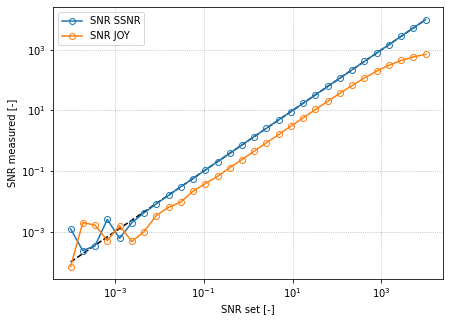

In [8]:
# Plot SNR calculations
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df['SNR'], df['SNR'], 'k--')
for s in ['SNR SSNR', 'SNR JOY']:
    ax.plot(df['SNR'], df[s], 'o-', mfc='none', label=s)
# Aesthetics
ax.set_xlabel('SNR set [-]')
ax.set_ylabel('SNR measured [-]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(ls=':')

## Batch of images with non-white noise
---

In [9]:
# Set up DataFrame
df = pd.DataFrame(columns=['SNR', 'SNR SSNR', 'SNR JOY'])
df['SNR'] = np.geomspace(1e-4, 1e4, 30)

for i, row in df.iterrows():
    SNR = row['SNR']

    # Generate noisy images
    noisy_1 = image + noise.nonwhite_noise(var/SNR, image.shape)
    noisy_2 = image + noise.nonwhite_noise(var/SNR, image.shape)

    # (S)SNR calculations
    df.loc[i, 'SNR SSNR'] = ssnr.SSNR_full([noisy_1, noisy_2])
    df.loc[i, 'SNR JOY'] = (ssnr.SNR_JOY(noisy_1) +
                            ssnr.SNR_JOY(noisy_2)) / 2

# Preview
df[::5]

,SNR,SNR SSNR,SNR JOY
0,0.000100,-0.000722627,0.095859
5,0.002395,0.00284235,0.0979403
10,0.057362,0.0576244,0.116665
15,1.373824,1.37201,0.599872
20,32.903446,32.9114,11.897
25,788.046282,787.412,213.11


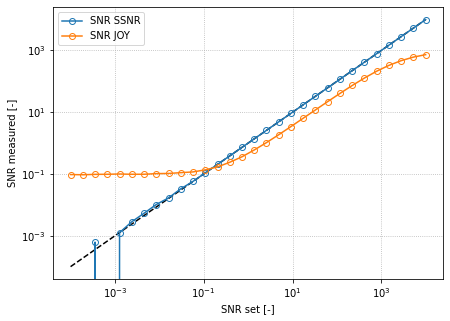

In [10]:
# Plot SNR calculations
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df['SNR'], df['SNR'], 'k--')
for s in ['SNR SSNR', 'SNR JOY']:
    ax.plot(df['SNR'], df[s], 'o-', mfc='none', label=s)
# Aesthetics
ax.set_xlabel('SNR set [-]')
ax.set_ylabel('SNR measured [-]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(ls=':')